<a href="https://colab.research.google.com/github/Alessandro5C/3D-ORGAN/blob/master/view_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf 3D-ORGAN
!git clone https://github.com/Alessandro5C/3D-ORGAN.git

Cloning into '3D-ORGAN'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 162 (delta 16), reused 22 (delta 9), pack-reused 123
Receiving objects: 100% (162/162), 124.15 MiB | 27.00 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (87/87), done.


In [2]:
import os

os.chdir("3D-ORGAN")
os.getcwd()

'/content/3D-ORGAN'

In [3]:
!pip install repackage
!pip install torch
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for repackage: filename=repackage-0.7.3-py3-none-any.whl size=3301 sha256=1c6a3f3d33e32e9ea268d0392a41ad3b4f5a19b016dbbd62f26a440bf045d825
  Stored in directory: /root/.cache/pip/wheels/19/60/1e/cd6dc672790cd0297e18f71895792b7681053e5f78e5db33dd
Successfully built repackage
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 985 kB/s 


In [8]:
!tar -xvzf datasets/voxels.tar.gz -C datasets/

voxels.npy


# Train

In [ ]:
!./run_experiments.sh

# Results

* Model: voxels-usegan

In [4]:
import numpy as np
import pandas as pd
from reconstruction.model import LoadModel
from reconstruction.utils.plot import plot_vol, plot_reconstruction
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
# Load model
model = LoadModel('chairnet', 'data/chair_shapenet/', opt='voxels-usegan', evaluate_mode=True)
# Load data
model._load_full_train_set()
voxels, voxels_target, labels = model.full_train_data

In [11]:
results_1 = model.predict(voxels, labels)
results_2 = model.predict(results_1, labels)

def maskedl1(target, incomplete, result):
    incomplete = incomplete.reshape(-1)
    target = target.reshape(-1)[incomplete == -1]
    result = result.reshape(-1)[incomplete == -1]
    l1 = np.abs(target - result)
    return np.mean(l1)

Loading models...
106/106 [==============================] - 17s 156ms/step


In [32]:
result_df = pd.DataFrame(columns=['label', 'input_l1', 'result_l1', 'result2_l1'])

for lbl in np.unique(labels):
    lbl_txt = model.label_encoder.inverse_transform([lbl])
    t_voxels, t_voxels_target = voxels[labels == lbl], voxels_target[labels == lbl]
    t_results_1, t_results_2 = results_1[labels == lbl], results_2[labels == lbl]
    l1_input = maskedl1(t_voxels_target, t_voxels, t_voxels)
    l1_it1 = maskedl1(t_voxels_target, t_voxels, t_results_1)
    l1_it2 = maskedl1(t_voxels_target, t_voxels, t_results_2)
    result_df.at[lbl, 'label'] = lbl_txt
    result_df.at[lbl, 'input_l1'] = l1_input
    result_df.at[lbl, 'result_l1'] = l1_it1
    result_df.at[lbl, 'result2_l1'] = l1_it2

result_df

,label,input_l1,result_l1,result2_l1
0,[1006be65e7bc937e9141f9b58470d646],0.037884,0.94836,1.021415
1,[1007e20d5e811b308351982a6e40cf41],0.020505,0.938426,1.016922
2,[100b18376b885f206ae9ad7e32c4139d],0.039909,0.947017,1.01914
3,[1013f70851210a618f2e765c4a8ed3d],0.018988,0.950785,1.0321
4,[1015e71a0d21b127de03ab2a27ba7531],0.029539,0.943054,1.017451
...,...,...,...,...
6773,[u6028f63e-4111-4412-9098-fe5f4f0c7c83],0.008185,0.936726,1.009872
6774,[ub5d972a1-de16-4d0a-aa40-85cd3a69aa8a],0.026442,0.941429,1.015638
6775,[uca24feec-f0c0-454c-baaf-561530686f40],0.025394,0.938767,1.012753
6776,[udf068a6b-e65b-430b-bc17-611b062e2e34],0.016201,0.942069,1.017358


In [43]:
results = pd.DataFrame()
for lbl in np.unique(labels):
    t_input = voxels[labels == lbl]
    t_target = voxels_target[labels == lbl]
    t_labels = labels[labels == lbl]
    t_result = model.predict(t_input, t_labels)
#     t_result = model.predict(t, t_labels)
    l1 = np.mean(np.abs(t_target - t_result))
    l1_original = np.mean(np.abs(t_target - t_input))
    print(model.label_encoder.inverse_transform([lbl])[0] + ': %.4f (%.4f)' % (l1, l1_original))

Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 37ms/step
9e36380dfd1364f6d01673c7c57450c9: 0.8289 (0.0035)
1/1 [==============================] - 0s 40ms/step
9e39c4ea1d69b2f19b1e9677d6cddea0: 0.9077 (0.0283)
1/1 [==============================] - 0s 41ms/step
9e3dba0e6fd3408bf382e154aede1b6a: 0.8257 (0.0386)
1/1 [==============================] - 0s 40ms/step
9e519ddc82bb9417813635269a32e293: 0.9084 (0.0074)
1/1 [==============================] - 0s 43ms/step
9e54053a1b16299153c5215ed09cc4b0: 0.9090 (0.0125)
1/1 [==============================] - 0s 42ms/step
9e5e03508b204754c2b64c0adffbe398: 0.9021 (0.0119)
1/1 [==============================] - 0s 30ms/step
9e6564dce4cc128efc24661f5f8d5d00: 0.8942 (0.0248)
1/1 [==============================] - 0s 34ms/step
9e65e8fdde35dcbef91663a74ccd2338: 0.8959 (0.0114)
1/1 [==============================] - 0s 48ms/step
9e6b834449ed2db86199d6fe090be061: 0.8649 (0.0107)
1/1 [================

In [44]:
train_log = pd.read_csv(model.training_log_file)
plt.figure(figsize=(15,4))
plt.plot(train_log.epoch, train_log.l1_loss_test, '-x', label='l1_test', linewidth=3, alpha=.75)
plt.plot(train_log.epoch, train_log.l1_loss_train, '-x', label='l1_train', linewidth=3, alpha=.75)
plt.ylim(0.0045, 0.0312)
plt.xlim(0)
plt.legend()
plt.show()

print('L1 loss per category (test dataset):')

results = pd.DataFrame()
for lbl in np.unique(labels):
    t_input = voxels[labels == lbl]
    t_target = voxels_target[labels == lbl]
    t_labels = labels[labels == lbl]
    t_result = model.predict(t_input, t_labels)
#     t_result = model.predict(t, t_labels)
    l1 = np.mean(np.abs(t_target - t_result))
    l1_original = np.mean(np.abs(t_target - t_input))
    print(model.label_encoder.inverse_transform(lbl) + ': %.4f (%.4f)' % (l1, l1_original))


FileNotFoundError: ignored

In [ ]:
model._evaluate(model.full_test_data)

0.087626636

In [ ]:
print(model.label_encoder.classes_)

['arq' 'bathtub' 'bed' 'chair' 'desk' 'dresser' 'monitor' 'night_stand'
 'sofa' 'table' 'toilet']


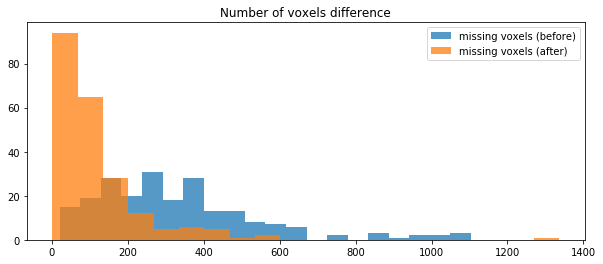

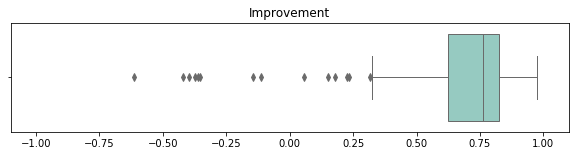

In [ ]:
lbl = model.label_encoder.transform(['arq'])[0]
arq_voxels = voxels[labels == lbl]
arq_voxels_target = voxels_target[labels == lbl]
arq_labels = labels[labels == lbl]
arq_result = model.predict(arq_voxels, arq_labels)
# Voxels original difference
voxels_diff = np.logical_xor(arq_voxels_target > 0, arq_voxels > 0)
voxels_diff = voxels_diff.reshape([arq_voxels.shape[0], -1])
voxels_diff = np.sum(voxels_diff, 1)
# Voxels result difference
voxels_result_diff = np.logical_xor(arq_voxels_target > 0, arq_result > 0)
voxels_result_diff = voxels_result_diff.reshape([arq_result.shape[0], -1])
voxels_result_diff = np.sum(voxels_result_diff, 1)
plt.figure(figsize=(10,4))
plt.hist(voxels_diff, bins=20, alpha=.75, label='missing voxels (before)')
plt.hist(voxels_result_diff, bins=20, alpha=.75, label='missing voxels (after)')
plt.title('Number of voxels difference')
plt.legend()
plt.show()
# Show improvement
improvement = (voxels_diff - voxels_result_diff) / voxels_diff
plt.figure(figsize=(10,2))
sns.boxplot(improvement, palette='Set3', linewidth=1, )
plt.title('Improvement')
plt.xlim(-1.1,1.1);

In [ ]:
# n_points = 3
# radius = 8
# model._load_full_test_set(min_points=n_points, max_points=n_points,
#                           min_radius=radius, max_radius=radius)
model._load_full_test_set(min_points=2, max_points=5,
                          min_radius=6, max_radius=10, sphere_chance=.9)
voxels, voxels_target, labels = model.full_test_data
result = model.predict(voxels, labels)

arq_voxels, arq_voxels_target, arq_labels, arq_result = voxels, voxels_target, labels, result

In [ ]:
lbl = model.label_encoder.transform(['arq'])[0]
arq_voxels = voxels[labels == lbl]
arq_voxels_target = voxels_target[labels == lbl]
arq_labels = labels[labels == lbl]
arq_result = model.predict(arq_voxels, arq_labels)

In [ ]:
# from reconstruction.utils.data_prep import get_fractured

# def multiplot(i, **kwargs):
#     frac = get_fractured(arq_voxels[i], **kwargs)
#     r = model.predict(np.expand_dims(arq_voxels[i], 0), np.asarray([labels[i]]))
#     plot_reconstruction(frac, r[0]>0)

# n = arq_voxels.shape[0]
# i = np.random.choice(n) # get random index
# plot_vol(arq_voxels_target[i])
# multiplot(i)
# multiplot(i)

In [ ]:
l1loss = lambda a, b: np.mean(np.abs(a - b))
n = arq_voxels.shape[0]

# Uncomment the desire choice
i = np.random.choice(n) # get random index
# i = np.random.choice(np.argsort(improvement)[::-1][:int(n*.07)]) # get good result
# i = np.random.choice(np.argsort(improvement)[:int(n*.07)]) # get bad result

print('Complete object:')
plot_vol(arq_voxels_target[i])
n_voxels_target = np.sum(arq_voxels_target[i] == 1)

size = 10
print('Fractured object (l1=%.4f):' % l1loss(arq_voxels_target[i], arq_voxels[i]))
n_voxels = np.sum(arq_voxels[i] == 1)
missing_points = n_voxels_target - n_voxels
perc_missing = missing_points * 100 / n_voxels_target
print(f'Missing voxels: {missing_points} (%.2f%%)' % perc_missing)
plot_vol(arq_voxels[i], s=size)

print('Reconstruction (l1=%.4f):' % l1loss(arq_voxels_target[i], arq_result[i]))
missing_points_result = np.sum((arq_voxels_target[i] + (arq_result[i] > 0)) == 0)
extra_points = np.sum((arq_voxels_target[i] + (arq_result[i] > 0)) == 1)
print(f'Missing voxels    : {missing_points} -> {missing_points_result}')
print(f'Extra voxels added: {extra_points}')
plot_reconstruction(arq_voxels[i], arq_result[i], s=size)
# plot_reconstruction(arq_voxels[i], arq_voxels_target[i], s=size)
rerecon = model.predict_one(arq_result[i], 'arq', decode_label=True)
plot_reconstruction(arq_voxels[i], rerecon[0], s=size)
rererecon = model.predict_one(arq_result[i], 'arq', decode_label=True)
plot_reconstruction(arq_voxels[i], rererecon[0], s=size)

Complete object:


Fractured object (l1=0.1426):
Missing voxels: 2336 (55.29%)


Reconstruction (l1=0.0983):
Missing voxels    : 2336 -> 331
Extra voxels added: 1262


In [ ]:
# n = voxels.shape[0]

# # Uncomment the desire choice
# i = np.random.choice(n) # get random index
# # i = np.random.choice(np.argsort(improvement)[::-1][:int(n*.07)]) # get good result
# # i = np.random.choice(np.argsort(improvement)[:int(n*.07)]) # get bad result

# print(f'Complete object ({model.label_encoder.inverse_transform(labels[i])}):')
# plot_vol(voxels_target[i])

# size = 10
# print('Fractured object (l1=%.4f):' % l1loss(voxels_target[i], voxels[i]))
# missing_points = np.sum((voxels_target[i] - voxels[i]))
# print(f'Missing voxels: {missing_points}')
# plot_vol(voxels[i], s=size)

# print('Reconstruction (l1=%.4f):' % l1loss(voxels_target[i], result[i]))
# missing_points_result = np.sum((voxels_target[i] + (result[i] > 0)) == 0)
# extra_points = np.sum((voxels_target[i] + (result[i] > 0)) == 1)
# print(f'Missing voxels    : {missing_points} -> {missing_points_result}')
# print(f'Extra voxels added: {extra_points}')
# plot_reconstruction(voxels[i], result[i], s=size)